In [91]:
import pandas as pd
import numpy as np
import random
import operator
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram

In [92]:
# Read the dataset
file_path = 'RWB_02112023195802159.csv'
data = pd.read_csv(file_path)

# Filter the dataset for 'Disposable income per capita' and 'Life expectancy at birth'
income_life_exp_data = data[data['Indicator'].isin(['Disposable income per capita', 'Life expectancy at birth'])]

# Pivot the data to have one row per region with both indicators
pivot_data = income_life_exp_data.pivot_table(index=['REG_ID', 'Regions', 'TIME', 'Time'], 
                                              columns='Indicator', 
                                              values='Value').reset_index()

# Normalize the features
scaler = MinMaxScaler()
features_to_cluster = pivot_data[['Disposable income per capita', 'Life expectancy at birth']]
normalized_features = scaler.fit_transform(features_to_cluster)
normalized_df = pd.DataFrame(normalized_features, columns=features_to_cluster.columns)


In [93]:
def cluster_distance_centroid_link(c1, c2):
    return math.sqrt((c2[1]-c1[1])**2+(c2[0]-c1[0])**2)

def find_min_clusters(clusters):
    curr_cluster_1 = 0
    curr_cluster_2 = 1
    curr_dist = -1
    for i in range(0, len(clusters)):
        for y in range(i+1, len(clusters)):
            new_dist = cluster_distance_centroid_link(clusters[i], clusters[y])
            if curr_dist < 0 or curr_dist > cluster_distance_centroid_link(clusters[i], clusters[y]):
                curr_cluster_1 = i
                curr_cluster_2 = y
                curr_dist = cluster_distance_centroid_link(clusters[i], clusters[y])
    return curr_cluster_1, curr_cluster_2, curr_dist

In [94]:
def hierarchical_clustering_linkage(df):
    # linkage used for dendrogram drawing
    linkage = []
    
    # List of current elements, in their x and y dimensions, zipped together
    curr_x = [x for x in df.iloc[:,0]]
    curr_y = [y for y in df.iloc[:,1]]
    curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
    
    # Indices of current clusters
    idxs = [i for i in normalized_df.index]
    
    # The number of items in each cluster
    items_per_cluster = [1 for i in range(0, len(curr_x))]

    while len(curr_clusters) > 1:
        # Get cluster indices and distances
        c1, c2, curr_dist = find_min_clusters(curr_clusters)
        
        # Specify new cluster centroids
        new_c = []
        new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
        new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
        
        # Remove old clusters from the set of current clusters
        curr_clusters.pop(c1)
        curr_clusters.pop(c2-1)
        
        # Increment for new cluster
        idxs.append(idxs[-1] + 1)
        
        # Add new cluster to list of clusters
        curr_clusters.append(new_c)
        
        # Update number of items per cluster, removing old ones and adding in new one
        num_items = items_per_cluster[c1] + items_per_cluster[c2]
        items_per_cluster.pop(c1)
        items_per_cluster.pop(c2-1)
        items_per_cluster.append(num_items)
        
        # Add new iteraion to linkage
        linkage.append([idxs[c1], idxs[c2], curr_dist, num_items])
        
        # Remove old cluster indices
        idxs.pop(c1)
        idxs.pop(c2-1)
    
    return linkage

In [95]:
linkage = hierarchical_clustering_linkage(normalized_df)
pd.DataFrame(linkage, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(linkage))])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,124,289,0.000033,2
cluster 5,223,224,0.000250,2
...,...,...,...,...
cluster 385,35,770,0.351924,59
cluster 386,772,773,0.367345,329
cluster 387,16,775,0.540456,330
cluster 388,346,776,0.582397,331


In [96]:
len(linkage)

389

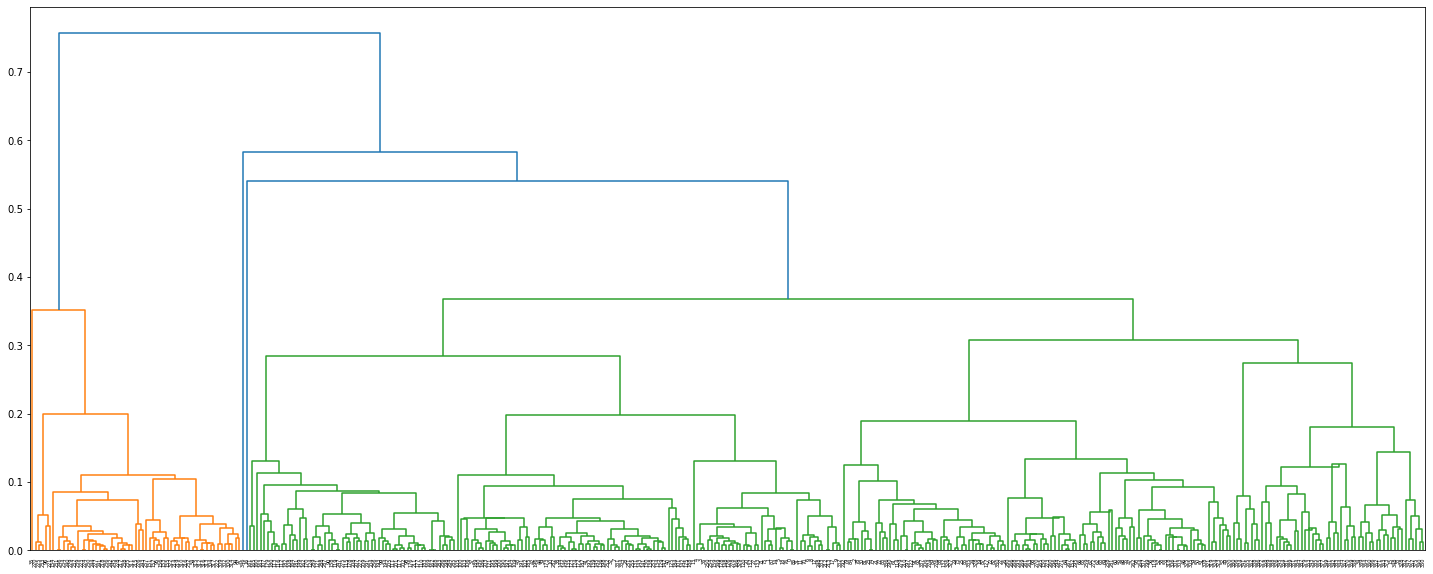

In [97]:
original_indices = [i for i in normalized_df.index]
fig = plt.figure(figsize=(25, 10))
row_dendr = dendrogram(linkage, labels=original_indices)
plt.show()

In [24]:
def cluster_distance_single_link(c1, c2):
    return math.sqrt((c2[1]-c1[1])**2+(c2[0]-c1[0])**2)

def find_min_clusters_single_link(clusters, elements_in_clusters):
    curr_cluster_1 = 0
    curr_cluster_2 = 1
    curr_dist = -1
    for i in range(0, len(clusters)):
        for y in range(i+1, len(clusters)):
            for x in range(0, len(elements_in_clusters[i])):
                for z in range(0, len(elements_in_clusters[y])):
                    new_dist = cluster_distance_single_link(elements_in_clusters[i][x], elements_in_clusters[y][z])
                    if curr_dist < 0 or curr_dist > new_dist:
                        curr_cluster_1 = i
                        curr_cluster_2 = y
                        curr_dist = new_dist
    return curr_cluster_1, curr_cluster_2, curr_dist

In [25]:
def hierarchical_clustering_linkage_single_link(df):
    # linkage used for dendrogram drawing
    linkage = []
    
    # List of current elements, in their x and y dimensions, zipped together
    curr_x = [x for x in df.iloc[:,0]]
    curr_y = [y for y in df.iloc[:,1]]
    curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
    elements_in_clusters = [[list(c)] for c in zip(curr_x, curr_y)]
    
    # Indices of current clusters
    idxs = [i for i in normalized_df.index]
    
    # The number of items in each cluster
    items_per_cluster = [1 for i in range(0, len(curr_x))]

    while len(curr_clusters) > 1:
        # Get cluster indices and distances
        c1, c2, curr_dist = find_min_clusters_single_link(curr_clusters, elements_in_clusters)
        new_clst_elem = elements_in_clusters[c1] + elements_in_clusters[c2]
        elements_in_clusters.pop(c1)
        elements_in_clusters.pop(c2-1)
        elements_in_clusters.append(new_clst_elem)
        
        # Specify new cluster centroids
        new_c = []
        new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
        new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
        
        # Remove old clusters from the set of current clusters
        curr_clusters.pop(c1)
        curr_clusters.pop(c2-1)
        
        # Increment for new cluster
        idxs.append(idxs[-1] + 1)
        
        # Add new cluster to list of clusters
        curr_clusters.append(new_c)
        
        # Update number of items per cluster, removing old ones and adding in new one
        num_items = items_per_cluster[c1] + items_per_cluster[c2]
        items_per_cluster.pop(c1)
        items_per_cluster.pop(c2-1)
        items_per_cluster.append(num_items)
        
        # Add new iteraion to linkage
        linkage.append([idxs[c1], idxs[c2], curr_dist, num_items])
        
        # Remove old cluster indices
        idxs.pop(c1)
        idxs.pop(c2-1)
    
    return linkage

In [26]:
linkage_2 = hierarchical_clustering_linkage_single_link(normalized_df)
pd.DataFrame(linkage_2, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(linkage_2))])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,124,289,0.000033,2
cluster 5,223,224,0.000250,2
...,...,...,...,...
cluster 385,768,773,0.084258,386
cluster 386,292,774,0.090395,387
cluster 387,16,775,0.196767,388
cluster 388,35,776,0.293535,389


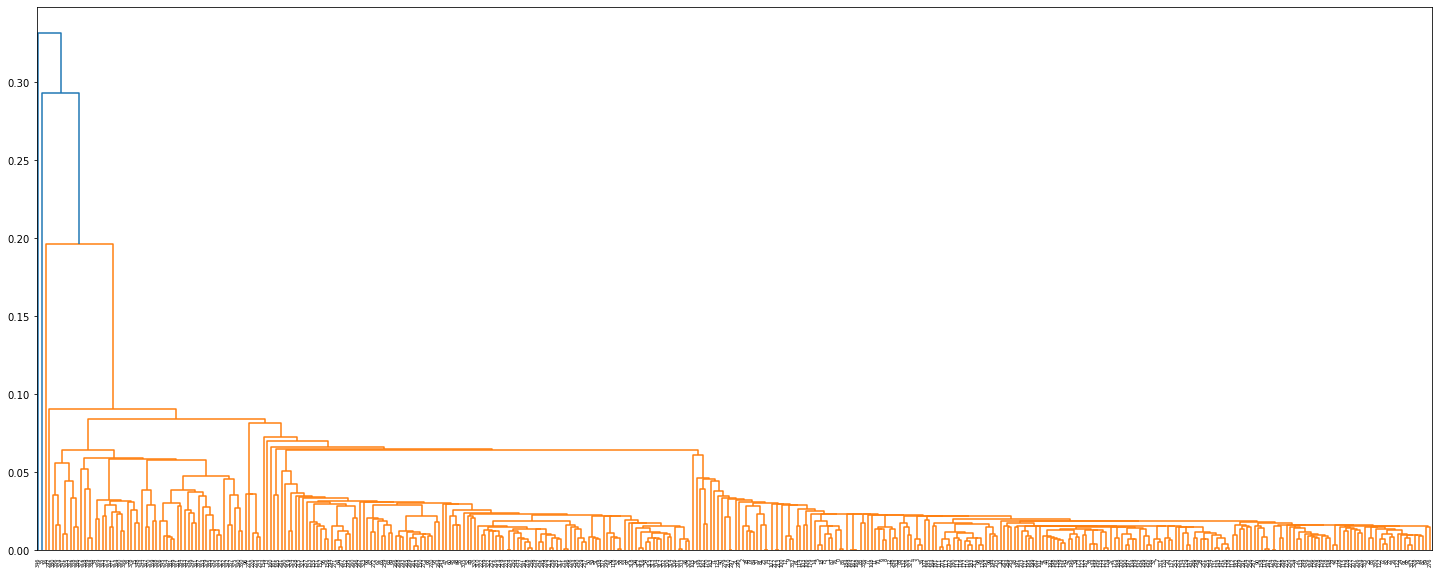

In [27]:
original_indices = [i for i in normalized_df.index]
fig = plt.figure(figsize=(25, 10))
row_dendr = dendrogram(linkage_2, labels=original_indices)
plt.show()

In [41]:
def cluster_distance_complete_link(c1, c2):
    return math.sqrt((c2[1]-c1[1])**2+(c2[0]-c1[0])**2)

def find_min_clusters_complete_link(clusters, elements_in_clusters):
    curr_cluster_1 = 0
    curr_cluster_2 = 1
    curr_dist = -1
    for i in range(0, len(clusters)):
        for y in range(i+1, len(clusters)):
            curr_group_dist = -1
            for x in range(0, len(elements_in_clusters[i])):
                for z in range(0, len(elements_in_clusters[y])):
                    new_dist = cluster_distance_complete_link(elements_in_clusters[i][x], elements_in_clusters[y][z])
                    if curr_group_dist <= new_dist:
                        curr_group_dist = new_dist
            if curr_dist < 0 or (curr_dist > curr_group_dist and curr_group_dist > -1):
                        curr_cluster_1 = i
                        curr_cluster_2 = y
                        curr_dist = curr_group_dist
    return curr_cluster_1, curr_cluster_2, curr_dist

In [42]:
def hierarchical_clustering_linkage_complete_link(df):
    # linkage used for dendrogram drawing
    linkage = []
    
    # List of current elements, in their x and y dimensions, zipped together
    curr_x = [x for x in df.iloc[:,0]]
    curr_y = [y for y in df.iloc[:,1]]
    curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
    elements_in_clusters = [[list(c)] for c in zip(curr_x, curr_y)]
    
    # Indices of current clusters
    idxs = [i for i in normalized_df.index]
    
    # The number of items in each cluster
    items_per_cluster = [1 for i in range(0, len(curr_x))]

    while len(curr_clusters) > 1:
        # Get cluster indices and distances
        c1, c2, curr_dist = find_min_clusters_complete_link(curr_clusters, elements_in_clusters)
        new_clst_elem = elements_in_clusters[c1] + elements_in_clusters[c2]
        elements_in_clusters.pop(c1)
        elements_in_clusters.pop(c2-1)
        elements_in_clusters.append(new_clst_elem)
        
        # Specify new cluster centroids
        new_c = []
        new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
        new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)
        
        # Remove old clusters from the set of current clusters
        curr_clusters.pop(c1)
        curr_clusters.pop(c2-1)
        
        # Increment for new cluster
        idxs.append(idxs[-1] + 1)
        
        # Add new cluster to list of clusters
        curr_clusters.append(new_c)
        
        # Update number of items per cluster, removing old ones and adding in new one
        num_items = items_per_cluster[c1] + items_per_cluster[c2]
        items_per_cluster.pop(c1)
        items_per_cluster.pop(c2-1)
        items_per_cluster.append(num_items)
        
        # Add new iteraion to linkage
        linkage.append([idxs[c1], idxs[c2], curr_dist, num_items])
        
        # Remove old cluster indices
        idxs.pop(c1)
        idxs.pop(c2-1)
    
    return linkage

In [43]:
linkage_3 = hierarchical_clustering_linkage_complete_link(normalized_df)
pd.DataFrame(linkage_3, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(linkage_3))])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,124,289,0.000033,2
cluster 5,223,224,0.000250,2
...,...,...,...,...
cluster 385,346,770,0.545018,29
cluster 386,767,769,0.583192,101
cluster 387,773,775,0.739825,323
cluster 388,772,776,1.000708,361


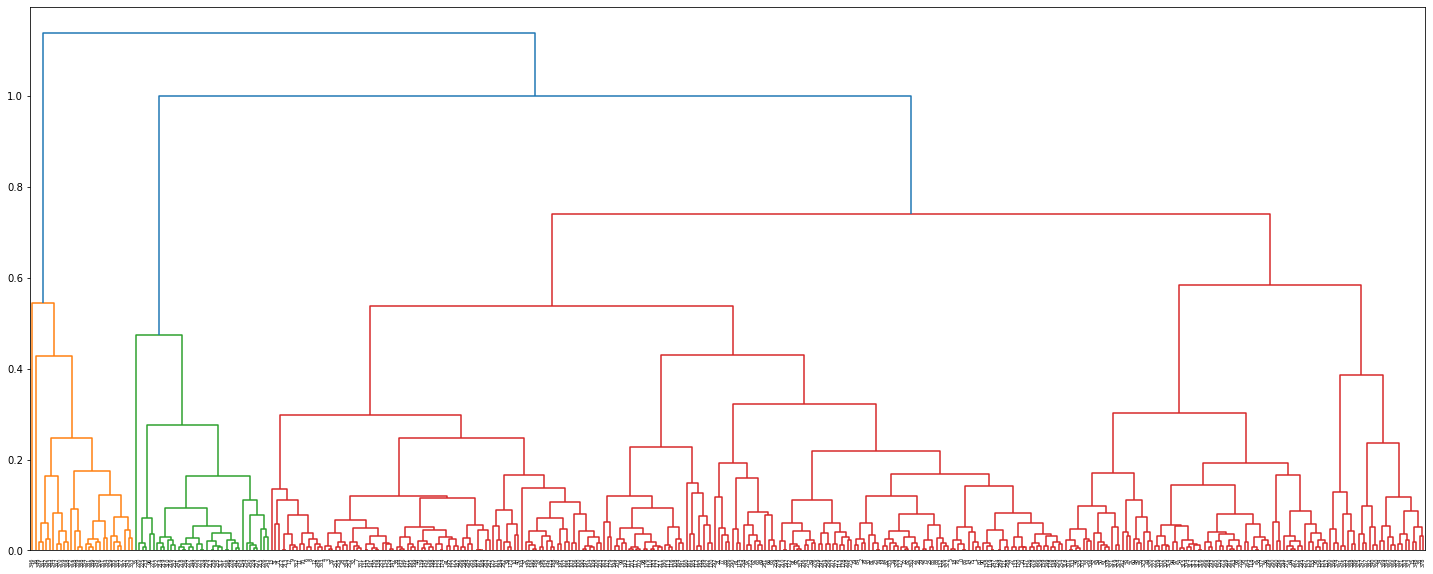

In [44]:
original_indices = [i for i in normalized_df.index]
fig = plt.figure(figsize=(25, 10))
row_dendr = dendrogram(linkage_3, labels=original_indices)
plt.show()

In [46]:
def initialize_membership_matrix(n, k):
    membership_mat = []
    for i in range(n):
        random_num_list = [random.random() for _ in range(k)]
        summation = sum(random_num_list)
        temp_list = [x / summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

# Update membership values based on the cluster centers
def update_membership_values(membership_mat, cluster_centers, df, m, k):
    p = float(2 / (m - 1))
    for i in range(len(df)):
        x = list(df.iloc[i])
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(distances[j] / distances[c], p) for c in range(k) if distances[c] != 0])
            membership_mat[i][j] = float(1 / den) if den != 0 else 0
    return membership_mat

# Calculate the centers of clusters using the membership matrix
def calculate_cluster_centers(membership_mat, df, m, k):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = []
    for j in range(k):
        x = list(cluster_mem_val[j])
        x_raised = [e ** m for e in x]
        denominator = sum(x_raised)
        temp_num = []
        for i in range(len(df)):
            data_point = list(df.iloc[i])
            prod = [x_raised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

In [81]:
df_cpy = normalized_df[:100].copy(deep=True)
curr_x = [x for x in normalized_df.iloc[:100,0]]
curr_y = [y for y in normalized_df.iloc[:100,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [i for i in normalized_df.index[:100]]
items_per_cluster = [1 for i in range(0, len(curr_x))]
n = len(normalized_df[:100])
k = len(curr_clusters)

mat = initialize_membership_matrix(n, k)
mat = update_membership_values(mat, curr_clusters, df_cpy, 2.00, k)

for m in range(0, len(mat)):
    mat[m][m] = 100
#     for x in range(0, len(mat[m])):
#         if mat[m][x] == 0:
#             mat[m][x] = 100
mat
# listzero = [x or 100 for x in m for m in mat]
# listzero[0]

[[100,
  0.002968219073222694,
  0.00021711966920703348,
  0.00045132668546851577,
  0.00048319005687883035,
  0.0018837167230206736,
  0.00014500143170504483,
  0.00010456897841088763,
  0.00014152532914180443,
  7.014850104599203e-05,
  5.4257232195156744e-05,
  0.00013653808725718516,
  9.612501731107406e-05,
  2.8440035556071056e-05,
  0.00258314224751776,
  9.441731646911447e-06,
  4.184825853861376e-06,
  7.641954103838437e-05,
  0.001967994843580886,
  0.0001219912428606207,
  0.00021943552593720435,
  3.767874027320281e-05,
  0.00024007579489674868,
  9.030126980436631e-05,
  0.0001685407441173359,
  0.000191788672681833,
  0.0002863437048385856,
  0.00015417866688634022,
  0.00019893153559717917,
  0.00013618642515988763,
  0.00012157252598818437,
  8.946581098057445e-05,
  9.039275938535806e-05,
  1.2331616352302344e-05,
  1.8793710094657924e-05,
  1.928906083218203e-06,
  0.0004295509039113147,
  3.128925468083131e-05,
  5.430051477943875e-05,
  4.385893662762556e-05,
  3.78

In [82]:
np.argwhere(mat == np.amin(mat))[0]

array([23, 96], dtype=int64)

In [86]:
# def find_min_fuzzy_clusters(clusters):
df_cpy = normalized_df.copy(deep=True)
fuzzy_linkage = []
curr_x = [x for x in df_cpy.iloc[:,0]]
curr_y = [y for y in df_cpy.iloc[:,1]]
curr_clusters = [list(c) for c in zip(curr_x, curr_y)]
idxs = [i for i in df_cpy.index]
items_per_cluster = [1 for i in range(0, len(curr_x))]
m = 2.00
n = len(df_cpy)
k = len(curr_clusters)
mat = initialize_membership_matrix(n, k)

while len(curr_clusters) > 1:
    n = len(df_cpy)
    k = len(curr_clusters)
    
    mat = initialize_membership_matrix(n, k)
    mat = update_membership_values(mat, curr_clusters, df_cpy, m, k)
#     print(f"mat len: {len(mat)}, k {k}")
    for m in range(0, len(mat)):
        mat[m][m] = 100
    new_clusters = np.argwhere(mat == np.amin(mat))[0]
    c1 = new_clusters[0]
    c2 = new_clusters[1]
    curr_dist = np.amin(mat)
#     new_dist = math.sqrt((curr_clusters[c1][0] - curr_clusters[c2][0])**2 + (curr_clusters[c1][1] - curr_clusters[c2][1])**2)
    print(f"c1 {c1} c2 {c2} curr dist {curr_dist}")
#     print(curr_clusters)
#     print(f"idxs {idxs}")

    # Specify new cluster centroids
    new_c = []
    new_c.append((curr_clusters[c1][0] + curr_clusters[c2][0])/2)
    new_c.append((curr_clusters[c1][1] + curr_clusters[c2][1])/2)

    # Remove old clusters from the set of current clusters
    curr_clusters.pop(c1)
    curr_clusters.pop(c2-1)

    # Drop old elements in dataframe
    df_cpy = df_cpy.drop([c1, c2])
    df_cpy = df_cpy.reset_index(drop=True)
    
    # Add in new cluster to dataframe
    df_cpy.loc[len(df_cpy)] = new_c
    
    # Increment for new cluster
    idxs.append(idxs[-1] + 1)

    # Add new cluster to list of clusters
    curr_clusters.append(new_c)

    # Update number of items per cluster, removing old ones and adding in new one
    num_items = items_per_cluster[c1] + items_per_cluster[c2]
    items_per_cluster.pop(c1)
    items_per_cluster.pop(c2-1)
    items_per_cluster.append(num_items)

    # Add new iteraion to linkage
    fuzzy_linkage.append([idxs[c1], idxs[c2], curr_dist, num_items])
    
    # Remove old cluster indices
    if c2 > c1:
        idxs.pop(c1)
        idxs.pop(c2-1)
    else:
        idxs.pop(c2)
        idxs.pop(c1-1)

c1 167 c2 168 curr dist 0.0
c1 167 c2 388 curr dist 0.0
c1 209 c2 210 curr dist 0.0
c1 284 c2 341 curr dist 0.0025706436108359843
c1 130 c2 35 curr dist 0.002577534480410752
c1 136 c2 34 curr dist 0.0025843786266155425
c1 132 c2 33 curr dist 0.002591176030273394
c1 32 c2 210 curr dist 0.0025921902813536226
c1 136 c2 208 curr dist 0.0026052317319690157
c1 129 c2 379 curr dist 0.0026121348488633758
c1 162 c2 92 curr dist 0.0026191239067924555
c1 91 c2 16 curr dist 0.0026232429285641674
c1 130 c2 205 curr dist 0.0026330348205114355
c1 122 c2 211 curr dist 0.002640168072917906
c1 122 c2 219 curr dist 0.0026487440184665046
c1 33 c2 194 curr dist 0.002655959931720781
c1 51 c2 15 curr dist 0.0026634222738490206
c1 14 c2 198 curr dist 0.0026654166867998083
c1 112 c2 199 curr dist 0.0026779686550008923
c1 219 c2 204 curr dist 0.002685275478133392
c1 203 c2 307 curr dist 0.0026885248128933775
c1 168 c2 205 curr dist 0.0026999444503103755
c1 109 c2 200 curr dist 0.002707295321628768
c1 33 c2 133 

c1 160 c2 142 curr dist 0.004855078528701477
c1 141 c2 99 curr dist 0.0048589781802315735
c1 98 c2 44 curr dist 0.004889597102404874
c1 43 c2 45 curr dist 0.004903449141445175
c1 127 c2 36 curr dist 0.004951445867641697
c1 35 c2 196 curr dist 0.004965252018314507
c1 139 c2 49 curr dist 0.0050010061204511114
c1 48 c2 76 curr dist 0.005007825430540197
c1 8 c2 54 curr dist 0.00505070801998719
c1 169 c2 35 curr dist 0.005076788706387189
c1 34 c2 75 curr dist 0.005087745896992192
c1 145 c2 11 curr dist 0.005128571502622582
c1 10 c2 91 curr dist 0.005129641393037133
c1 149 c2 36 curr dist 0.005182098993497927
c1 35 c2 86 curr dist 0.0051870425774401445
c1 92 c2 178 curr dist 0.005236333940282223
c1 161 c2 62 curr dist 0.0052633476231338985
c1 61 c2 158 curr dist 0.005282319996850146
c1 177 c2 42 curr dist 0.005320072356012866
c1 41 c2 184 curr dist 0.005323162674586044
c1 27 c2 178 curr dist 0.005376883003558457
c1 25 c2 34 curr dist 0.005407309913627286
c1 130 c2 74 curr dist 0.005436154429

In [87]:
flpd = pd.DataFrame(fuzzy_linkage, 
             columns=['row label 1', 'row label 2', 'distance', 'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(len(fuzzy_linkage))])
flpd

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,167,168,0.000000,2
cluster 2,169,390,0.000000,3
cluster 3,212,213,0.000000,2
cluster 4,289,346,0.002571,2
cluster 5,130,35,0.002578,2
...,...,...,...,...
cluster 385,768,767,0.138361,96
cluster 386,764,770,0.169103,95
cluster 387,773,775,0.235402,184
cluster 388,772,774,0.295239,184


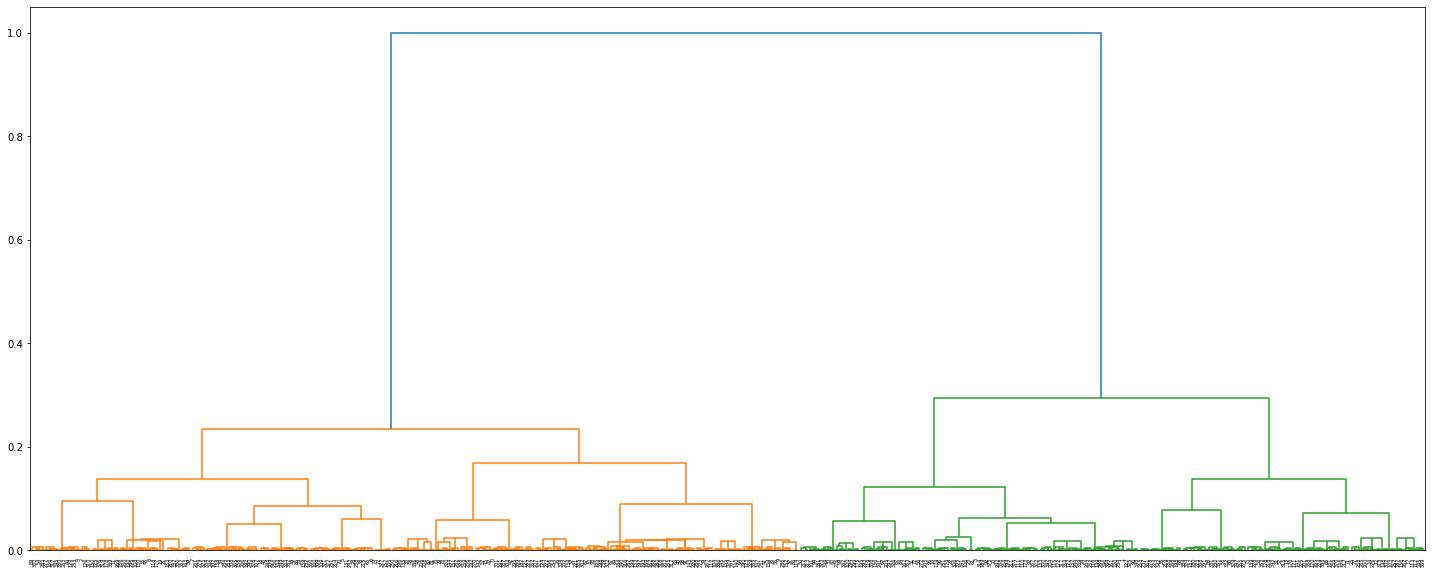

In [88]:
fuzzy_indices = [i for i in normalized_df[:100].index]
fig = plt.figure(figsize=(25, 10))
row_dendr = dendrogram(fuzzy_linkage)
plt.show()